##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Realistic Molecule Structure Visualization using GAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

### Setup

In [ ]:
!pip install Bio
!pip install pandas
!pip install numpy
!pip install pyvista

In [ ]:
import tensorflow as tf
from Bio.PDB import MMCIFParser
import pandas as pd
import numpy as np

In [ ]:
tf.__version__

'2.17.1'

### Get the downloaded files urls

In [ ]:
!sed -e 's|^|https://files.rcsb.org/download/|' -e 's|$|.cif|' data/pdb_ids.txt > data/urls.txt


In [ ]:
import requests
import os

# Path to the .txt file containing the comma-separated IDs
file_path = "data/pdb_ids.txt"  # Replace with the actual path to your .txt file

# Folder to save the downloaded files
output_folder = "data/"
os.makedirs(output_folder, exist_ok=True)

# URL prefix for downloading
url_prefix = "https://files.rcsb.org/download/"

# Read the .txt file and split the IDs
with open(file_path, "r") as f:
    content = f.read().strip()
    id_list = content.split(',')

# Download each file
for pdb_id in id_list:
    pdb_id = pdb_id.strip()  # Clean up any whitespace
    url = f"{url_prefix}{pdb_id}.cif"
    try:
        response = requests.get(url)
        response.raise_for_status()
        # Save the file
        with open(os.path.join(output_folder, f"{pdb_id}.cif"), "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {pdb_id}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {pdb_id}: {e}")


### Visualize the model using py3Dmol

In [ ]:
!pip install py3Dmol

In [ ]:
import py3Dmol

def visualize_cif(cif_file):
    # Read the content of the .cif file
    with open(cif_file, 'r') as f:
        cif_content = f.read()

    # Initialize the py3Dmol viewer
    view = py3Dmol.view(width=800, height=800)
    view.addModel(cif_content, "cif")  # Load .cif content
    view.setStyle({'cartoon': {'color': 'spectrum'}})  # Apply style
    view.zoomTo()  # Zoom to fit the structure
    return view

# Visualize a specific .cif file
cif_path = "data/4XA3.cif"  # Replace with your .cif file path
view = visualize_cif(cif_path)
view.show()


### Generate Images for all .cif files

In [ ]:
import os

# Folder with .cif files
cif_folder = "data/"  # Update with your .cif folder
html_output_folder = "html_visualizations/"
os.makedirs(html_output_folder, exist_ok=True)

def save_cif_as_html(cif_file, output_folder):
    # Read the content of the .cif file
    with open(cif_file, 'r') as f:
        cif_content = f.read()

    # Initialize the py3Dmol viewer
    view = py3Dmol.view(width=800, height=800)
    view.addModel(cif_content, "cif")
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.zoomTo()

    # Save the visualization as an HTML file
    html_path = os.path.join(output_folder, os.path.basename(cif_file).replace(".cif", ".html"))
    with open(html_path, 'w') as html_file:
        html_file.write(view._make_html())
    print(f"Saved HTML: {html_path}")

# Generate HTML for each .cif file
for cif_file in os.listdir(cif_folder):
    if cif_file.endswith(".cif"):
        save_cif_as_html(os.path.join(cif_folder, cif_file), html_output_folder)

# Zip the HTML files for easy download
import shutil
shutil.make_archive("html_visualizations", 'zip', html_output_folder)

# Download the zip file
from google.colab import files
files.download("html_visualizations.zip")


### Use pyppeteer to convert .html to .png
...takes a while

In [ ]:
!pip install pyppeteer


In [ ]:
import nest_asyncio
import asyncio
from pyppeteer import launch
import os

# Apply the nest_asyncio patch
nest_asyncio.apply()

# Input and output folders
html_folder = "html_visualizations/"  # Replace with your folder containing HTML files
png_folder = "png_images/"
os.makedirs(png_folder, exist_ok=True)

async def html_to_png(html_file, output_folder):
    browser = await launch(headless=True, args=['--no-sandbox'])
    page = await browser.newPage()
    html_path = f"file://{os.path.abspath(html_file)}"  # Local HTML file path
    await page.goto(html_path)
    output_path = os.path.join(output_folder, os.path.basename(html_file).replace(".html", ".png"))
    await page.screenshot({'path': output_path, 'fullPage': True})
    await browser.close()
    print(f"Saved PNG: {output_path}")

# Convert all HTML files
async def convert_all_html_to_png(html_folder, output_folder):
    for html_file in os.listdir(html_folder):
        if html_file.endswith(".html"):
            await html_to_png(os.path.join(html_folder, html_file), output_folder)

# Run the conversion
asyncio.run(convert_all_html_to_png(html_folder, png_folder))

# Zip the PNG folder for downloading
import shutil
shutil.make_archive("png_images", 'zip', png_folder)

# Download the zip file
from google.colab import files
files.download("png_images.zip")


In [ ]:
# Zip the PNG folder for downloading
import shutil
shutil.make_archive("png_images", 'zip', png_folder)

# Download the zip file
from google.colab import files
files.download("png_images.zip")

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [ ]:
from PIL import Image
import os
import numpy as np

# Define paths
image_folder = "png_images/"
1
os.makedirs(processed_folder, exist_ok=True)

# Resize and normalize images
image_size = (128, 128)  # Desired size (e.g., 128x128)

for image_file in os.listdir(image_folder):
    if image_file.endswith(".png"):
        img_path = os.path.join(image_folder, image_file)
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format
        img = img.resize(image_size)

        # Save processed image
        processed_path = os.path.join(processed_folder, image_file)
        img.save(processed_path)
        print(f"Processed: {processed_path}")


Processed: processed_images/4YWR.png
Processed: processed_images/4YGJ.png
Processed: processed_images/4ZDC.png
Processed: processed_images/4XFT.png
Processed: processed_images/4Y64.png
Processed: processed_images/4YVE.png
Processed: processed_images/4XI2.png
Processed: processed_images/4Z4R.png
Processed: processed_images/4Y9L.png
Processed: processed_images/4YIZ.png
Processed: processed_images/4Y4N.png
Processed: processed_images/4XV5.png
Processed: processed_images/4XF2.png
Processed: processed_images/4Z8D.png
Processed: processed_images/4ZCN.png
Processed: processed_images/4XWH.png
Processed: processed_images/4YBL.png
Processed: processed_images/4ZDL.png
Processed: processed_images/4XB9.png
Processed: processed_images/4Y5X.png
Processed: processed_images/4YFV.png
Processed: processed_images/4XWK.png
Processed: processed_images/4YKE.png
Processed: processed_images/4YRO.png
Processed: processed_images/4YWH.png
Processed: processed_images/4XE1.png
Processed: processed_images/4XFF.png
P

### Convert images to a dataset

In [ ]:

dataset = []
processed_folder = "processed_images/"  # Path to your processed PNG files
for image_file in os.listdir(processed_folder):
    img_path = os.path.join(processed_folder, image_file)
    img = Image.open(img_path).resize((128, 128))  # Ensure images are 128x128
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    dataset.append(img_array)

# Convert to NumPy array and print dataset shape
dataset = np.array(dataset)


In [ ]:
BUFFER_SIZE = 270
BATCH_SIZE = 32

In [ ]:
# Slice (horizontally), batch, and randomize order of the training data
# (divide train_images into smaller portions, where each "slice"
# is a subset of the data).
dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

LeakyReLU: https://miro.medium.com/max/1400/1*siH_yCvYJ9rqWSUYeDBiRA.png

tanh: https://www.programmerall.com/images/899/37/3754636d1395f0492a82d3c3514fa70b.png

Batch normalization: normalizes outputs using mean = 0, standard dev = 1; model trains faster, increases accuracy

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    # 100 random values will be input, connected densely to 8*8*256 nodes
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())  # centers & scales parameters--reduces overfitting
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))  # Initial shape: 8x8x256
    assert model.output_shape == (None, 8, 8, 256)

    # Upsample to 16x16x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 32x32x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 64x64x32
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 128x128x3
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model


Use the (as yet untrained) generator to create an image.

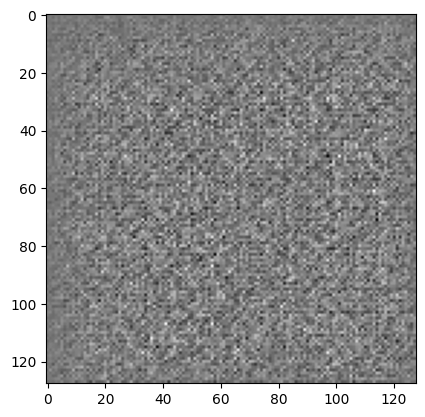

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # First convolutional block
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second convolutional block
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third convolutional block
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Fourth convolutional block
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and final dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # Output a probability (real or fake)

    return model


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.50004846]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.
https://gombru.github.io/assets/cross_entropy_loss/softmax_CE_pipeline.png


In [ ]:
# convenient name
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    # real_output should be 1 and fake output 0
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
We compare the discriminator's decisions on the generated images to an array of 1s. When we do this, the generator's loss will quantify how well it was able to trick the discriminator--if the generator is performing well, the discriminator will classify its generated fake images as real (1).

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Will reuse this seed over time (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# `tf.function` causes the function to be "compiled".
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = \
        disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients \
        (zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs, patience=10):
    best_gen_loss = float('inf')  # Initialize the best generator loss
    patience_counter = 0          # Counter for early stopping

    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = 0.0  # Track generator loss for the epoch
        num_batches = 0       # Count batches to compute average loss

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)  # Train for one batch
            epoch_gen_loss += gen_loss
            num_batches += 1

        # Average generator loss over the epoch
        epoch_gen_loss /= num_batches

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Epoch {epoch + 1}/{epochs} - Generator Loss: {epoch_gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")
        print('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time() - start))

        # Early stopping logic
        if epoch_gen_loss < best_gen_loss:
            best_gen_loss = epoch_gen_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs. No improvement in generator loss for {patience} epochs.")
            break

    # Generate images after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    print("Training complete.")

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

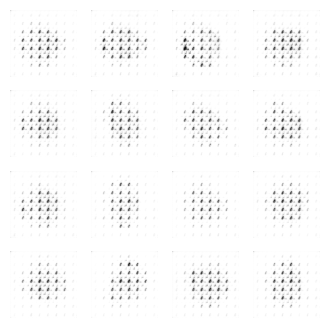

Training complete.


In [ ]:
# Train the GAN with early stopping
EPOCHS = 50
PATIENCE = 15

train(dataset, EPOCHS, patience=PATIENCE)


Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

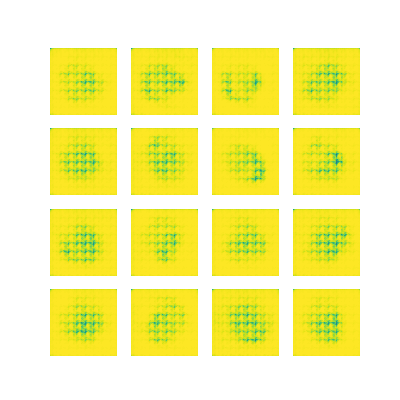

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-261-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-261-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
!pip install tensorflow_docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.8 MB/s eta 0:00:00



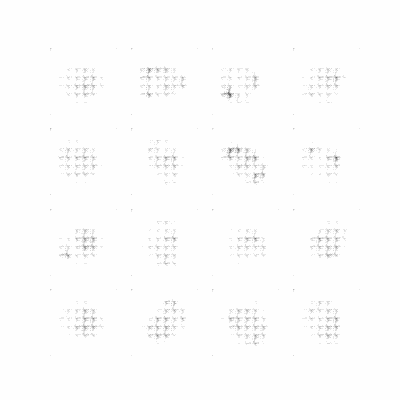

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
